In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from models import RVAEModel
from data_utils import DataFactory
tf.enable_eager_execution()
%matplotlib inline

/home/malzantot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/malzantot/Nesl/bio_gan/ecg_dataset.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/malzantot/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/malzantot/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/malzantot/anaconda3/lib/python3.6/site-packages/ipykernel_launcher

In [2]:
CHECKPOINT_DIR = './save/ecg_rvae_adv/07_22_14_39'


In [3]:
ecg_train, ecg_test, metadata = DataFactory.create_dataset('ecg_long')

['1 NSR', '4 AFIB']
['1 NSR', '4 AFIB']
(array([0, 1], dtype=int32), array([211, 102]))
['1 NSR', '4 AFIB']
['1 NSR', '4 AFIB']
(array([0, 1], dtype=int32), array([72, 33]))


In [4]:
model = RVAEModel(enc_rnn_units=128,z_dim=16,dec_rnn_units=128,num_feats=metadata.num_feats,num_labels=metadata.num_labels)

In [5]:
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))

### Evaluate

In [6]:
test_x, test_y = next(iter(ecg_test.shuffle(1000).batch(100)))
test_masks = []
test_originals = []
test_inputs = []
test_labels = []
mask_len = 30
for i in range(test_x.shape[0]):
    rand_pos = int(np.random.uniform(low=0, high=int(test_x[i].shape[0])-mask_len))
    test_sample = test_x[i].numpy()
    mask = np.ones_like(test_sample)
    drop_range = np.arange(rand_pos, rand_pos+mask_len)

    mask[drop_range,:]=0
    test_masks.append(np.expand_dims(mask,0))
    test_sample_masked = np.multiply(mask, test_sample)
    test_inputs.append(test_sample_masked)
    test_originals.append(test_sample)
    test_labels .append(test_y[i:i+1])

test_originals = np.array(test_originals)
test_masks = np.array(test_masks)
test_inputs = np.array(test_inputs)

Instructions for updating:
Colocations handled automatically by placer.


## Display reconstruction

In [7]:
### Compute MAE
abs_error = []
impute_outputs = []
for i, (x_orig, x_mask, x_in, x_label) in enumerate(zip(test_originals, test_masks, test_inputs, test_labels)):
    x_in_tf = tf.convert_to_tensor([x_in])
    impute_result = model.impute(x_in_tf, x_label, x_mask).numpy()
    impute_outputs.append(impute_result)
    abs_error.append(np.sum(np.abs(impute_result-x_orig)))
print ('MAE = ', np.mean(abs_error))


MAE =  1.9902108


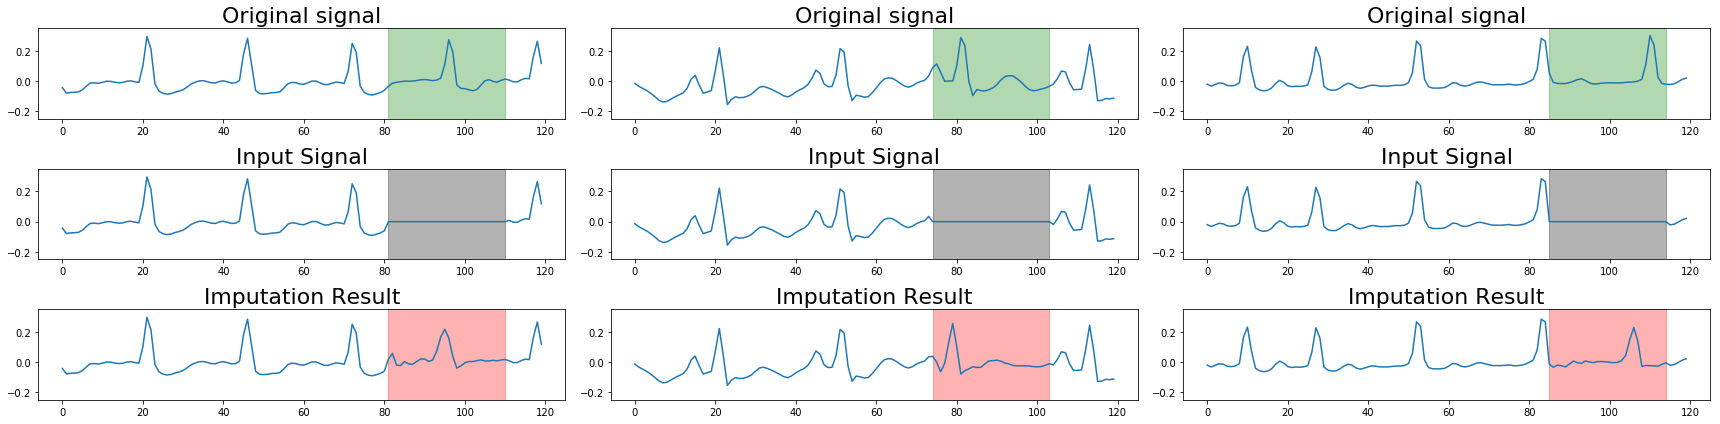

In [12]:
num_examples = 3
fig, axes = plt.subplots(3, num_examples, figsize=(24,6))
test_idxs = np.random.choice(len(test_masks),size=3,replace=False)
for idx in range(num_examples):
    test_idx = test_idxs[idx]
    test_mask = test_masks[test_idx]
    test_x_masked = test_inputs[test_idx]
    test_orig = test_originals[test_idx]
    test_result = impute_outputs[test_idx]
    
    drop_range = np.where(test_mask[0,:,0]==0)
    axes[0][idx].plot(test_orig[:,0])
    axes[0][idx].set_title('Original signal', fontsize=22)
    axes[0][idx].axvspan(np.min(drop_range), np.max(drop_range), color='green', alpha=0.3)
    axes[0][idx].set_ylim(-0.25, 0.35)

    axes[1][idx].set_title('Input Signal',fontsize=22)
    axes[1][idx].plot( test_x_masked[:,0])
    axes[1][idx].axhline(y=0,xmin=rand_pos-1, xmax=rand_pos+mask_len, color='red',linewidth=28)
    axes[1][idx].axvspan(np.min(drop_range), np.max(drop_range), color='black', alpha=0.3)
    axes[1][idx].set_ylim(-0.25, 0.35)

    axes[2][idx].plot(test_result[0,:,0])
    axes[2][idx].set_title('Imputation Result', fontsize=22)
    axes[2][idx].axvspan(np.min(drop_range), np.max(drop_range), color='red', alpha=0.3)
    axes[2][idx].set_ylim(-0.25, 0.35)

plt.tight_layout()

plt.savefig('imputation_result.png')